### **This notebook aims at extracting the impervious information by using the pre-trained model ( <font color=red>data process is implemented in Google Colab</font>)**

In [99]:
## Mount on google drive
from google.colab import drive
drive.mount('/content/drive/')
# Cloud authentication.
from google.colab import auth
auth.authenticate_user()


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### **We use Tensorflow 2.2.0 here!**

In [102]:
# !pip install tensorflow==2.2.0
import tensorflow as tf
print(tf.__version__)

2.2.0


In [103]:
import os
os.chdir("/content/drive/My Drive/Earth-Engine-with-Deep-Learning")
import matplotlib.pyplot as plt
import folium
import time
import json
from utils import imgShow


### **Note: the pretrained model is trained with tensorflow 2.2.0.**

In [119]:
## Super-parameter
resultPred_prefix = 'Impervious_sz_2019'
data_prefix = 'Pre_Landsat8_SZ_2019-'
##########################################################################
##### Google cloud platform: the pretrained model and output result path
Project = 'my-project-20200813'
Bucket = 'earth-engine-bucket-1'
Model_GS_path = 'gs://' + Bucket + '/ai_platform_train/unet_256_l8l5_20epoch/model'
result_gs_path = 'gs://' + Bucket + '/prediction_impervious_sz' + '/' + resultPred_prefix + '.TFRecord'

#### Google Drive: the pretrained model and output result directory
Model_Drive_path = '/content/drive/My Drive/Earth-Engine-with-Deep-Learning/models/pretrain/unet_MSMT_train_50epoch_CEloss/model'
data_folder = '/content/drive/My Drive/EE_Image/Landsat_image_sz'
result_drive_path = data_folder + '/' + resultPred_prefix + '.TFRecord'

#### Google Earth Engine: the output result (.TFRecord and .json) directory
ee_output_folder = 'users/xin_luo/Impervious_Mapping_SZ/result'
##########################################################################

## Bands corresponding to the tfrecord file
Bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7']   # specific for the Landsat 8
# Bands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']   # specific for Landsat 5
# data pipeline, the kernel shape and buffer should be consistency with the dataPred code
Kernel_size = [208, 208]  
Kernel_buffer = [48, 48]

buffered_shape = [                # patch size with the buffered region
    Kernel_size[0] + Kernel_buffer[0],
    Kernel_size[1] + Kernel_buffer[1]]

### Automatically obtain the multiple tfrecord files (<font color=red> **the tfrecord files are obtained by running the code: dataPreparation/dataPred** </font>).

In [120]:
# Get a list of all the files in the tfrecord data folder.
os.chdir(data_folder)

filesList = !ls -1 
PredFilesList = [s for s in filesList if data_prefix in s]
# Get the list of image files and the JSON mixer file.
tfrecordList = []
jsonFile = None
for f in PredFilesList:
    if f.endswith('.tfrecord.gz'):
        tfrecordList.append(f)
    elif f.endswith('.json'):
        jsonFile = f
tfrecordList.sort()
jsonFile_path = '/content/drive/My Drive/EE_Image/' +jsonFile

# Load the contents of the mixer file to a JSON object,and obtain the number of patches
jsonText = !cat {jsonFile}
mixer = json.loads(jsonText.nlstr)
patches = mixer['totalPatches']
mixer

{'patchDimensions': [208, 208],
 'patchesPerRow': 18,
 'projection': {'affine': {'doubleMatrix': [0.00026949458523585647,
    0.0,
    113.65934132322246,
    0.0,
    -0.00026949458523585647,
    22.955548770390255]},
  'crs': 'EPSG:4326'},
 'totalPatches': 180}

### Parse the tfrecord data and read the tfrecord data into the tf.data.Dataset

In [121]:
imageColumns = [
    tf.io.FixedLenFeature(shape=buffered_shape, dtype=tf.float32) 
      for k in Bands
  ]
featuresDict = dict(zip(Bands, imageColumns))    # 用于tfrecord文件中数据描述的字典

def parse_image(example_proto):
    return tf.io.parse_single_example(example_proto, featuresDict)

def toTensor(inputs):
    inputsList = [inputs.get(key) for key in Bands]
    stacked = tf.stack(inputsList, axis=0)
    stacked = tf.transpose(stacked, [1, 2, 0])
    return stacked

# Create a dataset from the TFRecord file(s) in Cloud Storage.
imageDataset = tf.data.TFRecordDataset(tfrecordList, compression_type='GZIP')
imageDataset = imageDataset.map(parse_image, num_parallel_calls=5)
imageDataset = imageDataset.map(toTensor).batch(1)
one_batch = iter(imageDataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


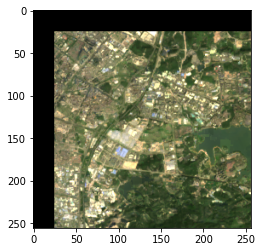

In [122]:
# ### visiallize the patch
# os.chdir("/content/drive/My Drive/Earth-Engine-with-Deep-Learning")
img = one_batch.next()
img = img[0].numpy()
imgShow(img, [2,1,0],1)


### **Prediction**: impervious surface mapping from satellite image

In [123]:
## load model
# model_pretrain = tf.keras.models.load_model(Model_GS_path)
model_pretrain = tf.keras.models.load_model(Model_Drive_path)
# model_pretrain.summary()
predictions = model_pretrain.predict(imageDataset, steps=patches, verbose=1)

180/180 [==============================] - 2s 13ms/step


In [124]:
i = 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3


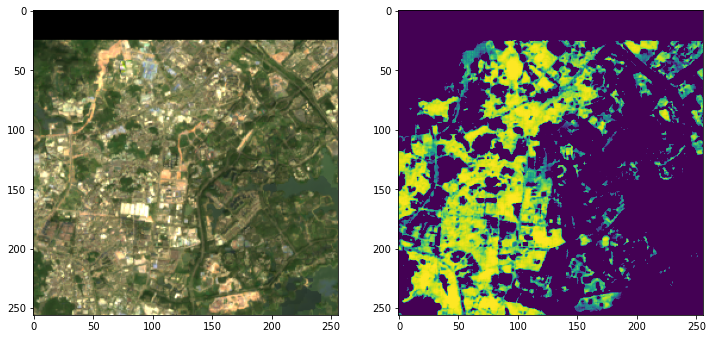

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
img = one_batch.next()
img = img[0].numpy()
imgShow(img, [2,1,0],1)
plt.subplot(1,2,2)
result = predictions[i]
plt.imshow(result[:,:,0], vmin=0.5, vmax=1)
print(i)
i += 1


### <font color=red> **Write the predictions into a tfrecord file.** </font>
### ！Write the result to the google cloud storage, and then upload to earth engine 

In [128]:
## Authenticate to Google Earth engine
from google.colab import auth
auth.authenticate_user()
# ## Authenticate to Earth Engine
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=pvQiCrgOQ57rCYEjStklDFYwTWZ97FTnnHRQP74ihh8&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/4QF45Lvqe6FKTcJfOb4Ogya99Z1XgwthsGgioFSd2h8N55mwWpkOSik

Successfully saved authorization token.


In [129]:
writer = tf.io.TFRecordWriter(result_gs_path)
i_patch = 0
for predPatch in predictions:
    print('Writing patch ' + str(i_patch) + '...')
    predPatch = predPatch[      # clip the overlay region
        Kernel_buffer[0]//2:Kernel_buffer[0]//2+Kernel_size[0], 
        Kernel_buffer[1]//2:Kernel_buffer[1]//2+Kernel_size[1]
        ]
    # Creat an example
    example = tf.train.Example(
      features=tf.train.Features(
        feature={
          'impervious': tf.train.Feature(
              float_list=tf.train.FloatList(
                  value=predPatch.flatten()))
        }
      )
    )
    # Write the example.
    writer.write(example.SerializeToString())
    i_patch += 1
writer.close()


Writing patch 0...
Writing patch 1...
Writing patch 2...
Writing patch 3...
Writing patch 4...
Writing patch 5...
Writing patch 6...
Writing patch 7...
Writing patch 8...
Writing patch 9...
Writing patch 10...
Writing patch 11...
Writing patch 12...
Writing patch 13...
Writing patch 14...
Writing patch 15...
Writing patch 16...
Writing patch 17...
Writing patch 18...
Writing patch 19...
Writing patch 20...
Writing patch 21...
Writing patch 22...
Writing patch 23...
Writing patch 24...
Writing patch 25...
Writing patch 26...
Writing patch 27...
Writing patch 28...
Writing patch 29...
Writing patch 30...
Writing patch 31...
Writing patch 32...
Writing patch 33...
Writing patch 34...
Writing patch 35...
Writing patch 36...
Writing patch 37...
Writing patch 38...
Writing patch 39...
Writing patch 40...
Writing patch 41...
Writing patch 42...
Writing patch 43...
Writing patch 44...
Writing patch 45...
Writing patch 46...
Writing patch 47...
Writing patch 48...
Writing patch 49...
Writing pa

### **Upload the result to the Earth Engine**

In [132]:
# 1. upload .json file from google drive to google storage
jsonFile_gs_dir = 'gs://' + Bucket+ '/prediction_impervious_sz/'
!gsutil -m cp -r '/content/drive/My Drive/EE_Image/Landsat_image_sz/Pre_Landsat8_SZ_2019*.json' {jsonFile_gs_dir}


Copying file:///content/drive/My Drive/EE_Image/Landsat_image_sz/Pre_Landsat8_SZ_2019-mixer.json [Content-Type=application/json]...
/ [1/1 files][  270.0 B/  270.0 B] 100% Done                                    
Operation completed over 1 objects/270.0 B.                                      


In [134]:
# !pip install oauth2client==3.0.0
# 2. upload both the .TFRecord file and .json file from google storage to the earth engine.
ee_output_image = ee_output_folder + '/' + resultPred_prefix
jsonFile_gs_path = 'gs://' + Bucket+ '/prediction_impervious_sz/' + jsonFile
!earthengine upload image --asset_id={ee_output_image} {result_gs_path} {jsonFile_gs_path}


Instructions for updating:
non-resource variables are not supported in the long term
Running command using Cloud API.  Set --no-use_cloud_api to go back to using the API

I0920 04:35:48.155720 140711089481600 discovery.py:894] URL being requested: GET https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/algorithms?prettyPrint=false&alt=json
I0920 04:35:49.217617 140711089481600 discovery.py:894] URL being requested: POST https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/image:import?alt=json
Started upload task with ID: WK5EL4U6KHKID254PNMYQ42O


### The impervious surface can be visuallized util the result are uploaded to the earth engine. 

In [ ]:
out_image = ee.Image(ee_output_folder + '/' + resultPred_prefix)

mapid = out_image.getMapId({'min': 0, 'max': 1})
map = folium.Map(location=[22.65, 114.17])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='predicted impervious',
  ).add_to(map)
map.add_child(folium.LayerControl())
map